In [172]:
%pip install wordcloud
%pip install textblob

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
import warnings

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# 1. Load and prepare the dataset
# Read the CSV file
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [174]:

# Read the CSV file
df = pd.read_csv(r"C:\Users\Hp\Documents\Spam_SMS.csv")

# Display the shape of the dataframe
print('DataFrame shape: ' + str(df.shape))

# Check for duplicate rows and remove them
print('Number of duplicate rows: ' + str(df.duplicated().sum()))
spam_df = df.drop_duplicates()
print('DataFrame shape after removing duplicates: ' + str(df.shape))




DataFrame shape: (5574, 2)
Number of duplicate rows: 415
DataFrame shape after removing duplicates: (5574, 2)


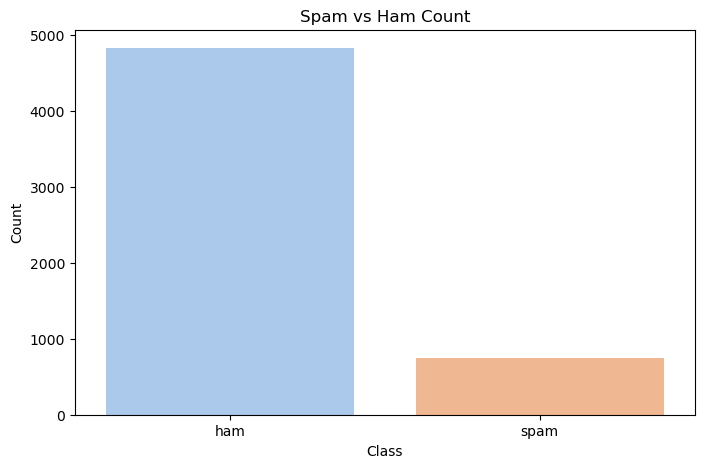

In [175]:
# Plotting distribution of spam vs ham
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Class', palette='pastel')
plt.title('Spam vs Ham Count')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

warnings.filterwarnings("ignore")


In [176]:
# Create a message length feature
df['Message_Length'] = df['Message'].apply(len)


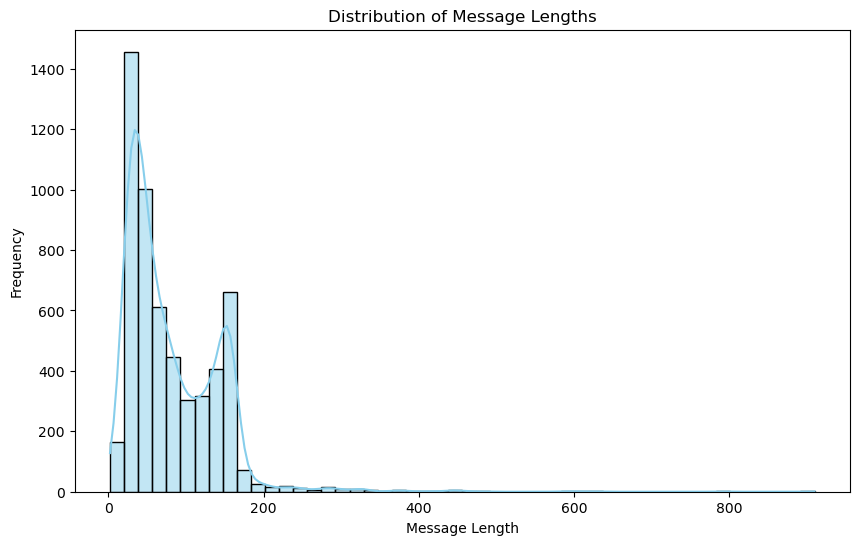

In [177]:
# Histogram of message lengths
plt.figure(figsize=(10,6))
sns.histplot(df['Message_Length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()


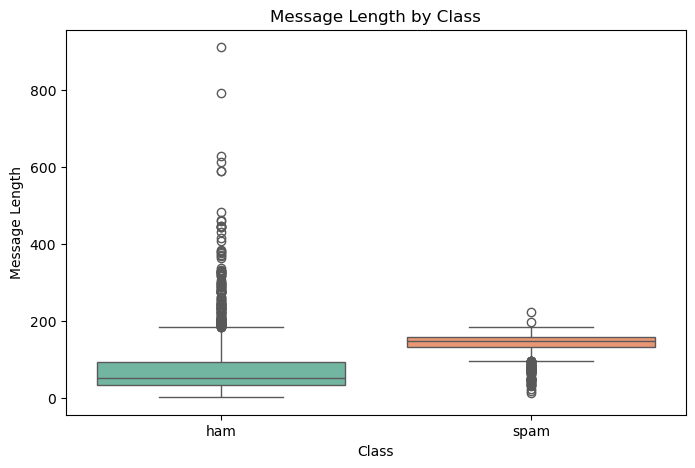

In [178]:
# Boxplot of message lengths by class
plt.figure(figsize=(8,5))
sns.boxplot(x='Class', y='Message_Length', data=df, palette='Set2')
plt.title('Message Length by Class')
plt.xlabel('Class')
plt.ylabel('Message Length')
plt.show()


warnings.filterwarnings("ignore")

In [179]:
df['Capitalized_Words'] = df['Message'].apply(lambda x: sum(1 for word in x.split() if word.isupper()))

In [180]:
from textblob import TextBlob

# Add sentiment polarity as a feature
df['Sentiment_Polarity'] = df['Message'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [181]:
# Word count (already implemented)
df['Word_Count'] = df['Message'].apply(lambda x: len(x.split()))

In [182]:
# Define the list of specific words
specific_words = ['free', 'win', 'offer', 'urgent', 'cash']

# Create a new feature that counts the occurrences of any specific word in the message
df['Specific_Words_Count'] = df['Message'].apply(
    lambda x: sum(1 for word in specific_words if word in x.lower())
)

In [183]:
import string

df['Punctuation_Count'] = df['Message'].apply(lambda x: sum(1 for char in x if char in string.punctuation))

In [184]:
# Calculate summary statistics for message length by class
print('\
Summary statistics for message length by class:')
print(df.groupby('Class')['Message_Length'].describe())


Summary statistics for message length by class:
        count        mean        std   min    25%    50%    75%    max
Class                                                                 
ham    4827.0   71.440232  58.321812   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.634538  28.854103  13.0  133.0  149.0  157.0  223.0


In [185]:
# Encode categorical variables: Convert 'Class' to numeric
df['Class_Encoded'] = df['Class'].map({'ham': 0, 'spam': 1})


In [186]:
# Check the encoding
print('\
Encoded class head:')
print(df[['Class', 'Class_Encoded']].head())



Encoded class head:
  Class  Class_Encoded
0   ham              0
1   ham              0
2  spam              1
3   ham              0
4   ham              0


In [187]:
# Count the number of special characters in each message
import re
df['Special_Char_Count'] = df['Message'].apply(lambda x: len(re.findall('[^a-zA-Z0-9\s]', x)))

warnings.filterwarnings("ignore")


In [188]:
# Count the number of digits in each message
df['Digit_Count'] = df['Message'].apply(lambda x: len(re.findall('\d', x)))



warnings.filterwarnings("ignore")

In [189]:
# Display the head of the dataframe with new features
print('\
DataFrame head with new features:')
print(df.head())


DataFrame head with new features:
  Class                                            Message  Message_Length  \
0   ham  Go until jurong point, crazy.. Available only ...             111   
1   ham                      Ok lar... Joking wif u oni...              29   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...             155   
3   ham  U dun say so early hor... U c already then say...              49   
4   ham  Nah I don't think he goes to usf, he lives aro...              61   

   Capitalized_Words  Sentiment_Polarity  Word_Count  Specific_Words_Count  \
0                  0                0.15          20                     0   
1                  0                0.50           6                     0   
2                  2                0.30          28                     2   
3                  2                0.10          11                     0   
4                  1                0.00          13                     0   

   Punctuation_Count  Class_

In [190]:
# Update the features list for the heatmap
features = ['Is_Spam', 'Is_Ham', 'Message_Length', 'Word_Count', 'Special_Char_Count', 'Digit_Count', 
            'Sentiment_Polarity', 'Capitalized_Words', 'Punctuation_Count', 'Specific_Words_Count']

# Calculate the correlation matrix
# Add important features to the correlation matrix calculation
important_features = ['Is_Spam', 'Is_Ham', 'Message_Length', 'Word_Count', 'Special_Char_Count', 'Digit_Count', 
                      'Sentiment_Polarity', 'Capitalized_Words', 'Punctuation_Count', 'Specific_Words_Count']
# Ensure the columns 'Is_Spam' and 'Is_Ham' are added to the dataframe
df['Is_Spam'] = (df['Class'] == 'spam').astype(int)
df['Is_Ham'] = (df['Class'] == 'ham').astype(int)

# Calculate the correlation matrix
correlation_matrix = df[important_features].corr()

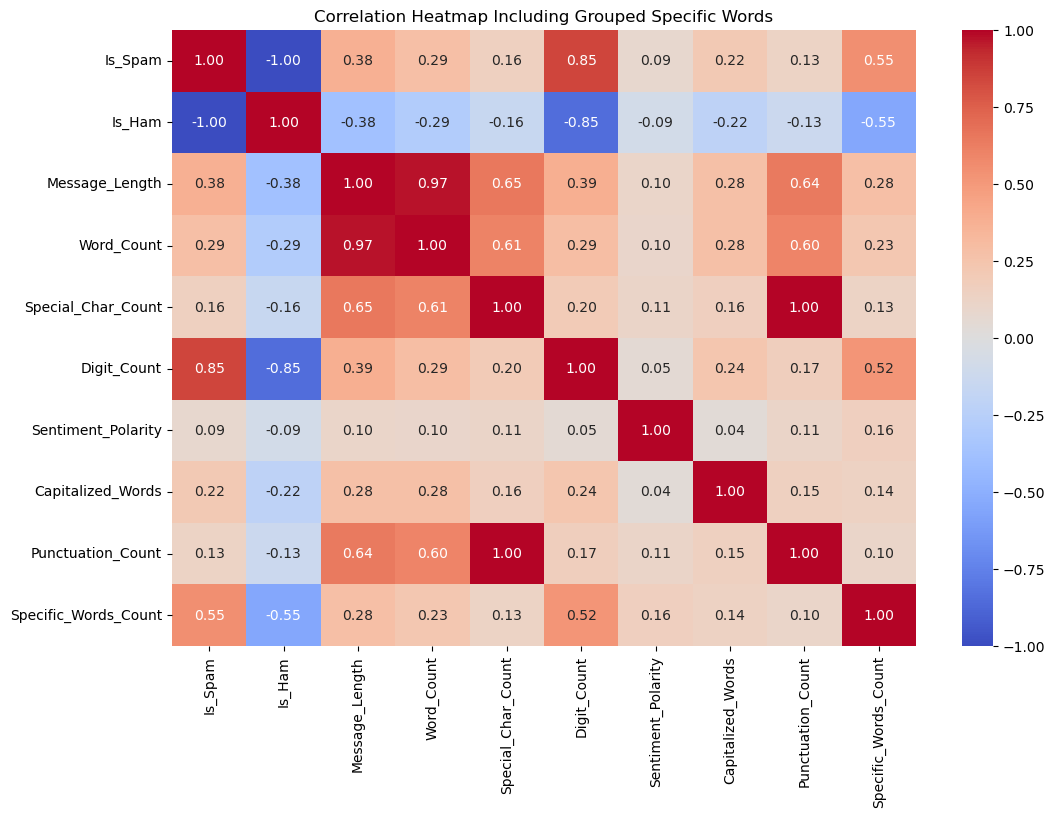

In [191]:
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap Including Grouped Specific Words')
plt.show()

Variance of each feature:
Message_Length          3581.045902
Word_Count               129.742446
Special_Char_Count        21.779517
Digit_Count               39.089844
Sentiment_Polarity         0.085569
Capitalized_Words          7.925333
Punctuation_Count         21.408371
Specific_Words_Count       0.132648
dtype: float64


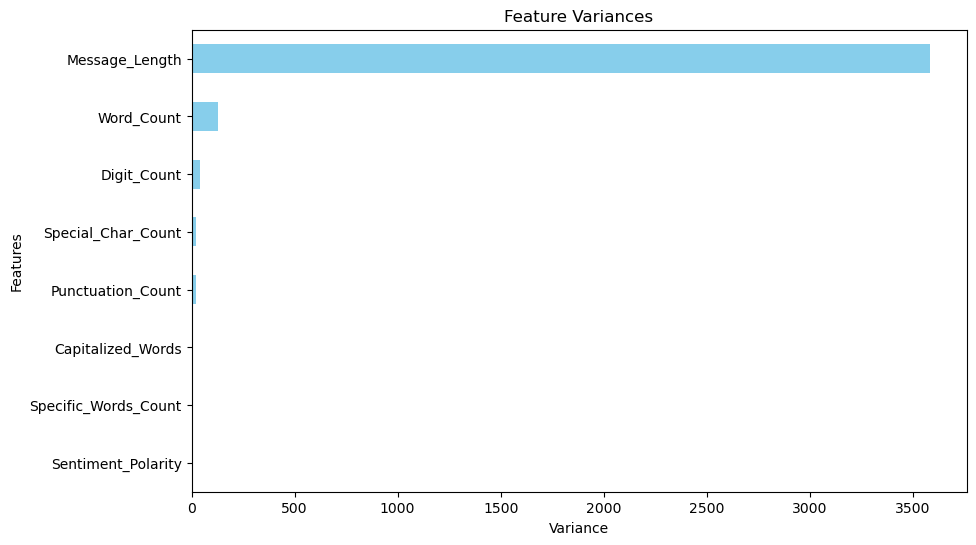


Selected Features by Variance Threshold (Threshold=0.01):
['Message_Length', 'Word_Count', 'Special_Char_Count', 'Digit_Count', 'Sentiment_Polarity', 'Capitalized_Words', 'Punctuation_Count', 'Specific_Words_Count']

Mutual Information Scores:
                Feature  Mutual_Information
3           Digit_Count            0.303463
0        Message_Length            0.148923
1            Word_Count            0.120028
7  Specific_Words_Count            0.106154
5     Capitalized_Words            0.086610
2    Special_Char_Count            0.043268
4    Sentiment_Polarity            0.040066
6     Punctuation_Count            0.031444

Top Features by Mutual Information:
['Digit_Count', 'Message_Length', 'Word_Count', 'Specific_Words_Count', 'Capitalized_Words']

Final Selected Features (Combined):
['Specific_Words_Count', 'Special_Char_Count', 'Word_Count', 'Sentiment_Polarity', 'Message_Length', 'Capitalized_Words', 'Punctuation_Count', 'Digit_Count']

Final DataFrame with Selected Fea

In [192]:
# Feature Selection using Variance Threshold and Mutual Information
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt

# Define features and target
features = ['Message_Length', 'Word_Count', 'Special_Char_Count', 'Digit_Count', 
            'Sentiment_Polarity', 'Capitalized_Words', 'Punctuation_Count', 'Specific_Words_Count']
X = df[features]
y = df['Class_Encoded']

# 1. Variance Threshold
# Calculate variance for each feature
variances = X.var()
print("Variance of each feature:")
print(variances)

# Plot the variances for visualization
plt.figure(figsize=(10, 6))
variances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Variances')
plt.xlabel('Variance')
plt.ylabel('Features')
plt.show()

# Set a threshold (e.g., 0.01) to remove low-variance features
optimal_threshold = 0.01
var_thresh = VarianceThreshold(threshold=optimal_threshold)
X_var_thresh = var_thresh.fit_transform(X)

# Get the selected feature names
selected_features_var = [features[i] for i in range(len(features)) if var_thresh.variances_[i] > optimal_threshold]
print(f"\nSelected Features by Variance Threshold (Threshold={optimal_threshold}):")
print(selected_features_var)

# 2. Mutual Information
# Compute mutual information between features and the target
mutual_info = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame to display feature importance
mutual_info_df = pd.DataFrame({'Feature': features, 'Mutual_Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual_Information', ascending=False)
print("\nMutual Information Scores:")
print(mutual_info_df)

# Select top features based on mutual information (e.g., top 5)
top_features_mi = mutual_info_df.nlargest(5, 'Mutual_Information')['Feature'].tolist()
print("\nTop Features by Mutual Information:")
print(top_features_mi)

# Combine selected features from both methods
final_selected_features = list(set(selected_features_var + top_features_mi))
print("\nFinal Selected Features (Combined):")
print(final_selected_features)

# Update the feature set for modeling
X_selected = df[final_selected_features]

# Display the final selected features
print("\nFinal DataFrame with Selected Features:")
print(X_selected.head())

In [193]:
# Scaling numerical features
from sklearn.preprocessing import StandardScaler

# Define the features to scale (incorporating all selected features so far)
features_to_scale = [
    'Message_Length', 'Word_Count', 'Special_Char_Count', 'Digit_Count',
    'Sentiment_Polarity', 'Capitalized_Words', 'Punctuation_Count', 'Specific_Words_Count'
]

# Apply StandardScaler to scale the features
scaler = StandardScaler()
df[[f'Scaled_{col}' for col in features_to_scale]] = scaler.fit_transform(df[features_to_scale])

# Display the head of the dataframe with scaled features
print("Head with scaled features:")
print(df[[col for col in df.columns if 'Scaled_' in col]].head())

Head with scaled features:
   Scaled_Message_Length  Scaled_Word_Count  Scaled_Special_Char_Count  \
0               0.510637           0.387054                   1.005355   
1              -0.859765          -0.842156                   0.362466   
2               1.245974           1.089459                   0.362466   
3              -0.525520          -0.403152                   0.362466   
4              -0.324974          -0.227551                  -0.494719   

   Scaled_Digit_Count  Scaled_Sentiment_Polarity  Scaled_Capitalized_Words  \
0           -0.381243                   0.081175                 -0.378127   
1           -0.381243                   1.277776                 -0.378127   
2            3.617717                   0.594004                  0.332367   
3           -0.381243                  -0.089768                  0.332367   
4           -0.381243                  -0.431654                 -0.022880   

   Scaled_Punctuation_Count  Scaled_Specific_Words_Count  


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.92      0.93      0.92       149

    accuracy                           0.98      1115
   macro avg       0.95      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



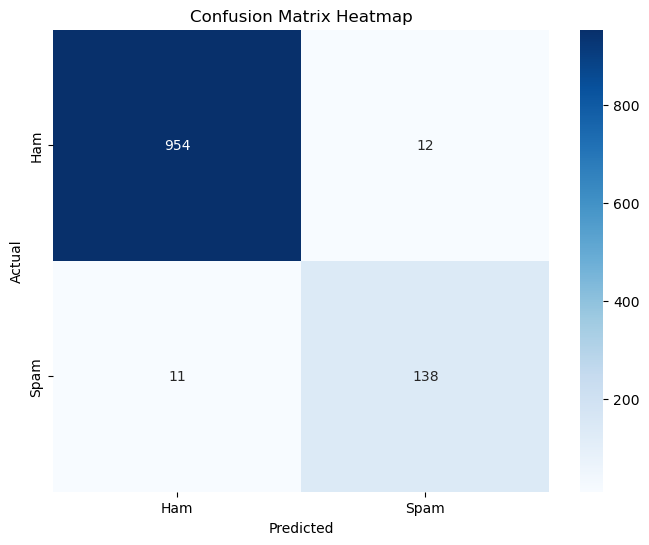

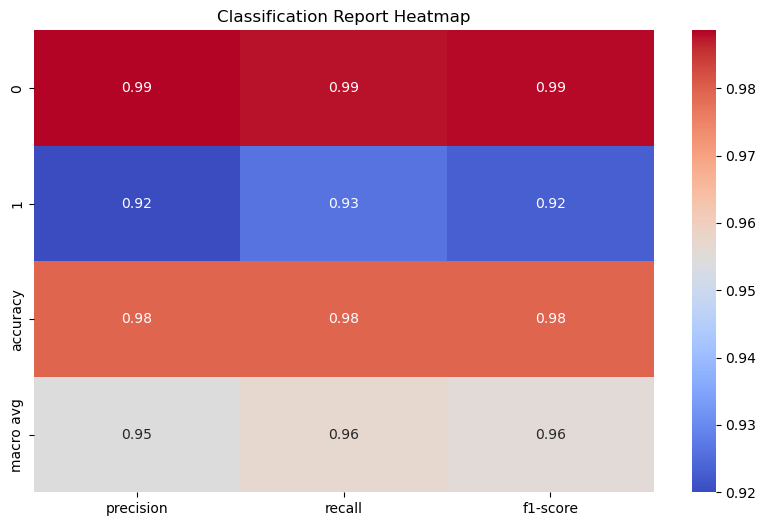

In [194]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Evaluate the model
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
# Generate a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate a classification report as a heatmap
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()

In [195]:
# Save the preprocessed dataframe
df.to_csv('preprocessed_spam_sms.csv', index=False)
print('\
Preprocessed data saved to preprocessed_spam_sms.csv')

print('Preprocessing and EDA completed.')

Preprocessed data saved to preprocessed_spam_sms.csv
Preprocessing and EDA completed.


In [196]:
df= pd.read_csv('preprocessed_spam_sms.csv')

print('Dataset shape:', df.shape)
print('Class distribution:')
print(df['Class'].value_counts())


Dataset shape: (5574, 21)
Class distribution:
Class
ham     4827
spam     747
Name: count, dtype: int64


In [197]:
# Split the data into features and target
X = df['Message']  # We'll use the raw text for text vectorization
y = df['Class_Encoded']



In [198]:
# Additional numerical features
numerical_features = df[['Message_Length', 'Word_Count', 'Special_Char_Count', 'Digit_Count']]


In [199]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, num_train, num_test = train_test_split(
    X, y, numerical_features, test_size=0.2, random_state=42, stratify=y
)

print('Training set shape:', X_train.shape)
print('Testing set shape:', X_test.shape)



Training set shape: (4459,)
Testing set shape: (1115,)


In [200]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_curve, auc
)

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test, model_name, labels=["Ham", "Spam"]):
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Inference Time: {end_time - start_time:.4f} seconds")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))
    
    # ROC Curve if the model supports predict_proba
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }



In [201]:
# Create a list to store model results
model_results = []


In [202]:
print("Starting model training and evaluation...")
print("done")


Starting model training and evaluation...
done


In [203]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


Training Naive Bayes with TF-IDF...

Naive Bayes with TF-IDF Results:
Accuracy: 0.9767
Precision: 0.9920
Recall: 0.8322
F1 Score: 0.9051
Inference Time: 0.0302 seconds


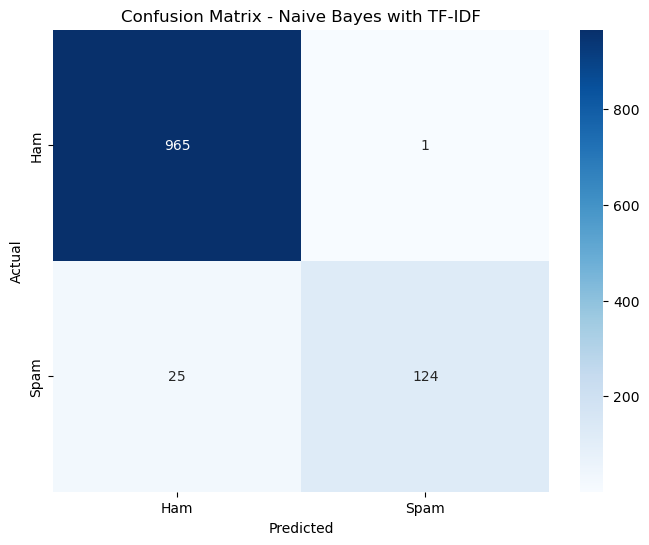


Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.99       966
        Spam       0.99      0.83      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



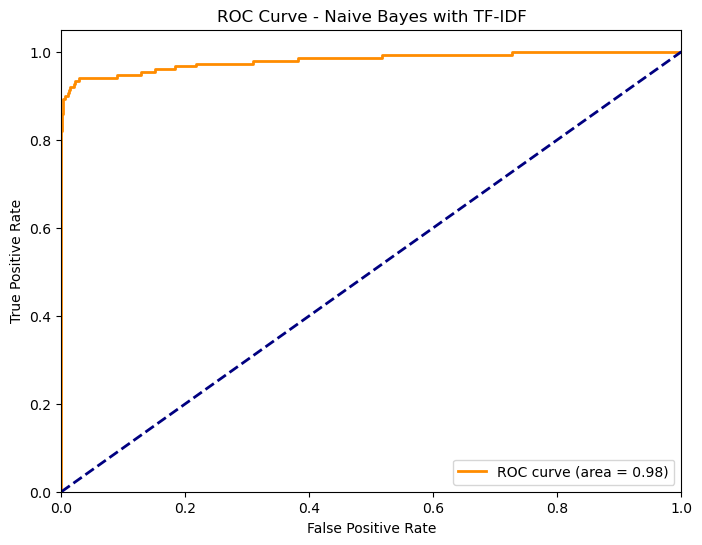

Naive Bayes with TF-IDF completed.


In [204]:
# Model 1: Naive Bayes with TF-IDF
print("Training Naive Bayes with TF-IDF...")
nb_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', MultinomialNB())
])

nb_tfidf.fit(X_train, y_train)
nb_results = evaluate_model(nb_tfidf, X_test, y_test, "Naive Bayes with TF-IDF")
model_results.append(nb_results)

print("Naive Bayes with TF-IDF completed.")


Training Logistic Regression with TF-IDF...

Logistic Regression with TF-IDF Results:
Accuracy: 0.9776
Precision: 1.0000
Recall: 0.8322
F1 Score: 0.9084
Inference Time: 0.0359 seconds


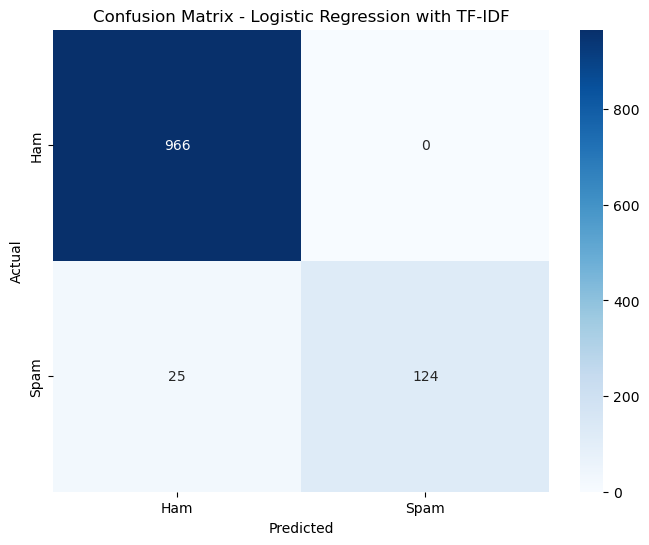


Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.99       966
        Spam       1.00      0.83      0.91       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



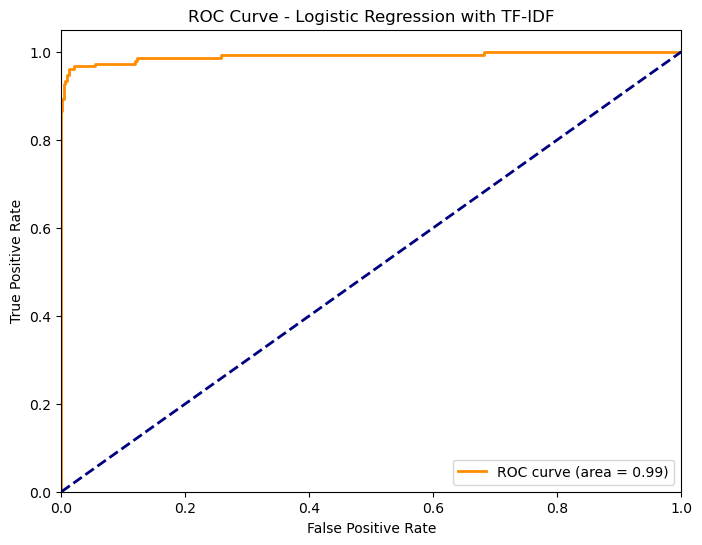

Logistic Regression with TF-IDF completed.


In [205]:
# Model 2: Logistic Regression with TF-IDF
print("Training Logistic Regression with TF-IDF...")
lr_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

lr_tfidf.fit(X_train, y_train)
lr_results = evaluate_model(lr_tfidf, X_test, y_test, "Logistic Regression with TF-IDF")
model_results.append(lr_results)

print("Logistic Regression with TF-IDF completed.")

Training Random Forest with TF-IDF...

Random Forest with TF-IDF Results:
Accuracy: 0.9776
Precision: 1.0000
Recall: 0.8322
F1 Score: 0.9084
Inference Time: 0.0799 seconds


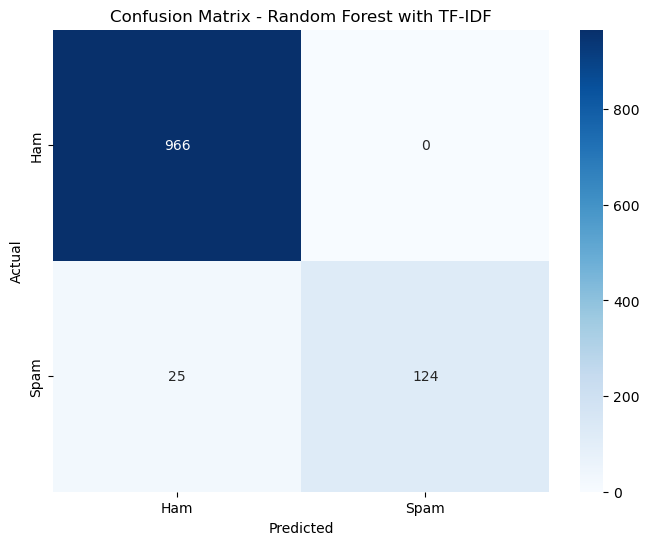


Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.99       966
        Spam       1.00      0.83      0.91       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



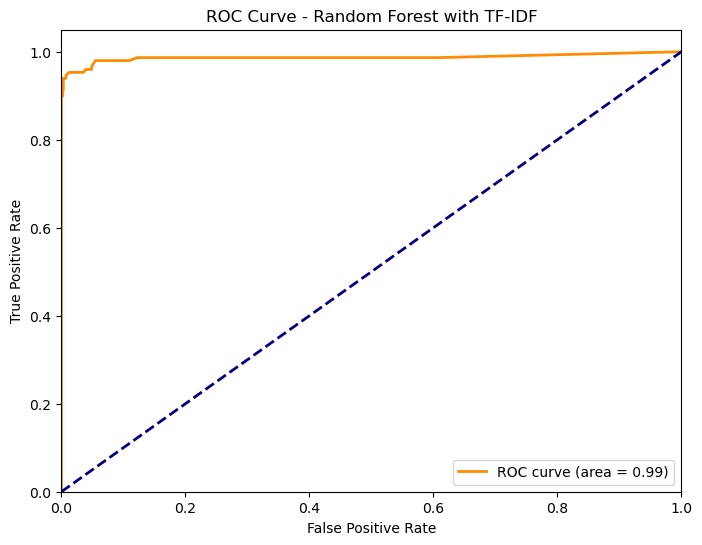

Random Forest with TF-IDF completed.


In [206]:
# Model: Random Forest with TF-IDF
print("Training Random Forest with TF-IDF...")

rf_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_tfidf.fit(X_train, y_train)
rf_results = evaluate_model(rf_tfidf, X_test, y_test, "Random Forest with TF-IDF")
model_results.append(rf_results)

print("Random Forest with TF-IDF completed.")


In [207]:
from sklearn.ensemble import VotingClassifier

# Model 4: Ensemble Voting Classifier
# We need to create fresh estimators, not use the already fitted pipelines
print("Training Ensemble Voting Classifier with TF-IDF...")

# Create a shared TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Create base classifiers
nb = MultinomialNB()
lr = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create and train the ensemble
ensemble = VotingClassifier(
    estimators=[
        ('nb', nb),
        ('lr', lr),
        ('rf', rf)
    ],
    voting='soft'
)

# Train the ensemble on the vectorized data
ensemble.fit(X_train_tfidf, y_train)

# Evaluate the ensemble
start_time = time.time()
y_pred = ensemble.predict(X_test_tfidf)
inference_time = time.time() - start_time

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)  
recall = recall_score(y_test, y_pred, pos_label=1)


f1 = f1_score(y_test, y_pred, pos_label=1)

# Print results
print("\
Ensemble Voting Classifier Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Inference Time: {inference_time:.4f} seconds")

print("\
Classification Report:")
print(classification_report(y_test, y_pred))

# Create a result dictionary for the ensemble
ensemble_results = {
    'Model': 'Ensemble Voting Classifier with TF-IDF',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Inference Time': inference_time
}

# Add to model results

model_results = []  # Ensure this is declared before appending

model_results.append(ensemble_results)

print("Ensemble Voting Classifier completed.")

# Print summary of model results
print("\
Summary of Model Results:")
for result in model_results:
    print(f"Model: {result['Model']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision: {result['Precision']:.4f}")
    print(f"Recall: {result['Recall']:.4f}")
    print(f"F1 Score: {result['F1 Score']:.4f}")
    print(f"Inference Time: {result['Inference Time']:.4f} seconds")
    print()

print("done")

Training Ensemble Voting Classifier with TF-IDF...
Ensemble Voting Classifier Results:
Accuracy: 0.9767
Precision: 1.0000
Recall: 0.8255
F1 Score: 0.9044
Inference Time: 0.0333 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.83      0.90       149

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Ensemble Voting Classifier completed.
Summary of Model Results:
Model: Ensemble Voting Classifier with TF-IDF
Accuracy: 0.9767
Precision: 1.0000
Recall: 0.8255
F1 Score: 0.9044
Inference Time: 0.0333 seconds

done


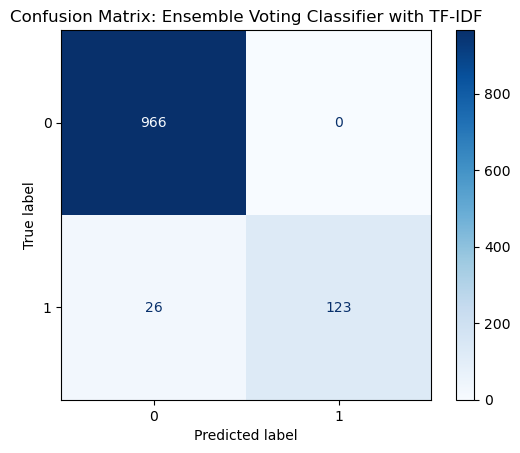

In [208]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')  # 'Blues' for better visualization

# Show the plot
plt.title("Confusion Matrix: Ensemble Voting Classifier with TF-IDF")
plt.show()


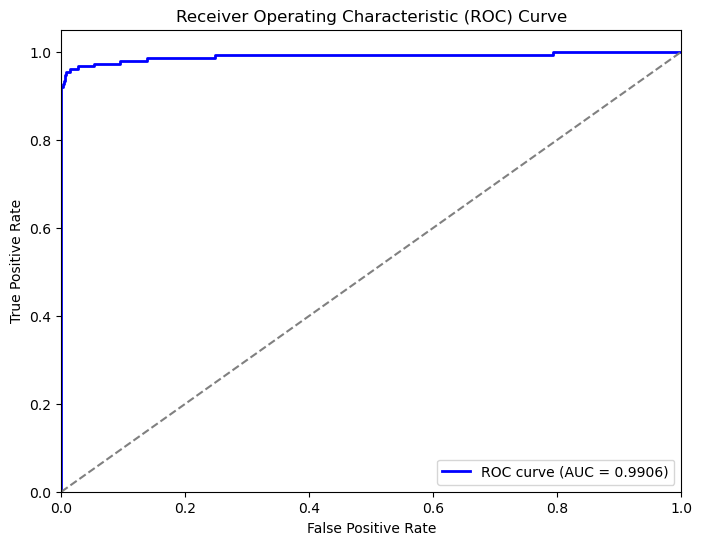

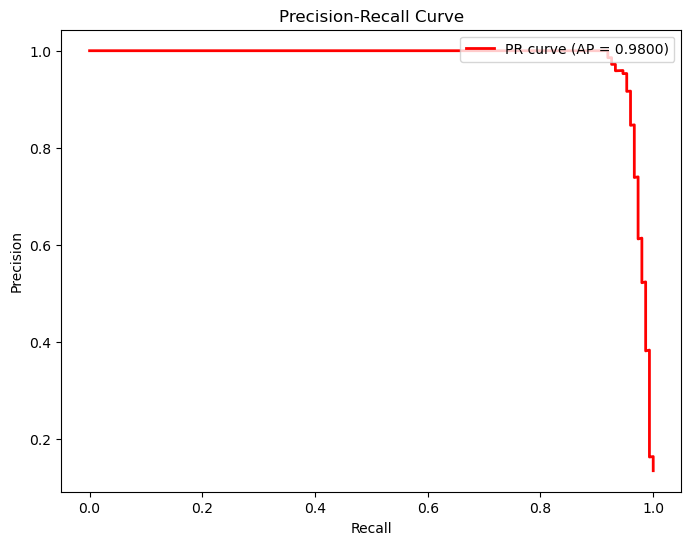

In [209]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class (Spam = 1)
y_probs = ensemble.predict_proba(X_test_tfidf)[:, 1]  # Probability of class 1


fpr, tpr, _ = roc_curve(y_test, y_probs)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='red', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()
